# Create Your Own Visualizations!
Instructions:
1. Install tensor2tensor and train up a Transformer model following the instruction in the repository https://github.com/tensorflow/tensor2tensor.
2. Update cell 3 to point to your checkpoint, it is currently set up to read from the default checkpoint location that would be created from following the instructions above.
3. If you used custom hyper parameters then update cell 4.
4. Run the notebook!

In [1]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

# Data

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json

import tensorflow as tf
import numpy as np
import os  
os.environ['CUDA_VISIBLE_DEVICES']='3'

import sys
sys.path.append('../')
from tpu import tpu_trainer_lib
from utils import t2t_model
from utils import decoding
from utils import devices
from models import transformer
from visualization import attention
from data_generators import translate_ende

import os
# PUT THE MODEL YOU WANT TO LOAD HERE!

PROBLEM = 'translate_ende_wmt_bpe32k'
MODEL = 'transformer'
HPARAMS = 'transformer_big_single_gpu'
print(HPARAMS)

# DATA_DIR=os.path.expanduser('~/t2t_data')
# TRAIN_DIR=os.path.expanduser('~/t2t_train/%s/%s-%s' % (PROBLEM, MODEL, HPARAMS))
DATA_DIR=os.path.expanduser('~/pycharmproject/T2T/double_model/t2t-datagen')
TRAIN_DIR=os.path.expanduser('~/pycharmproject/T2T/double_model/t2t-train')
print(TRAIN_DIR)

FLAGS = tf.flags.FLAGS
FLAGS.problems = PROBLEM
FLAGS.hparams_set = HPARAMS
FLAGS.data_dir = DATA_DIR
FLAGS.model = MODEL

FLAGS.schedule = 'train_and_evaluate'

hparams = tpu_trainer_lib.create_hparams(FLAGS.hparams_set, data_dir=FLAGS.data_dir, problem_name=PROBLEM)
hparams.use_fixed_batch_size = True
hparams.batch_size = 1

# SET EXTRA HYPER PARAMS HERE!
#hparams.null_slot = True

mode = tf.estimator.ModeKeys.EVAL

problem = hparams.problem_instances[0]
inputs, target = problem.input_fn(
      mode=mode,
      hparams=hparams,
      data_dir=DATA_DIR)

features = inputs
features['targets'] = target

def encode(string):
    subtokenizer = hparams.problems[0].vocabulary['inputs']
    return [subtokenizer.encode(string) + [1] + [0]]

def decode(ids):
    return hparams.problems[0].vocabulary['targets'].decode(np.squeeze(ids))

def to_tokens(ids):
    ids = np.squeeze(ids)
    subtokenizer = hparams.problems[0].vocabulary['targets']
    tokens = []
    for _id in ids:
        if _id == 0:
            tokens.append('<PAD>')
        elif _id == 1:
            tokens.append('<EOS>')
        else:
            tokens.append(subtokenizer._subtoken_id_to_subtoken_string(_id))
    return tokens

/home/ycliu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


transformer_big_single_gpu
/home/ycliu/pycharmproject/T2T/double_model/t2t-train
INFO:tensorflow:Reading data files from /home/ycliu/pycharmproject/T2T/double_model/t2t-datagen/translate_ende_wmt_bpe32k-dev*


# Model

In [3]:
decode_hparams = decoding.decode_hparams('')
model_fn = t2t_model.T2TModel.make_estimator_model_fn(
    MODEL,
    hparams,
    decode_hparams=decode_hparams)
est_spec = model_fn(features, target, mode)

with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    beam_out = model_fn(features, target, tf.contrib.learn.ModeKeys.INFER)

INFO:tensorflow:Unsetting shared_embedding_and_softmax_weights.
INFO:tensorflow:Unsetting shared_embedding_and_softmax_weights.
INFO:tensorflow:Beam Decoding with beam size 4


# Session

In [7]:
# Can't use this 
sv = tf.train.Supervisor(
    logdir=TRAIN_DIR,
    global_step=tf.Variable(0, dtype=tf.int64, trainable=False, name='global_step'))
sess = sv.PrepareSession(config=tf.ConfigProto(allow_soft_placement=True))
sv.StartQueueRunners(
    sess,
    tf.get_default_graph().get_collection(tf.GraphKeys.QUEUE_RUNNERS))

INFO:tensorflow:Restoring parameters from /home/ycliu/pycharmproject/T2T/double_model/t2t-train/model.ckpt-300000
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path /home/ycliu/pycharmproject/T2T/double_model/t2t-train/model.ckpt
INFO:tensorflow:Starting queue runners.


[]

INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.DataLossError'>, corrupted record at 0
	 [[Node: IteratorGetNext = IteratorGetNext[output_shapes=[[?,?,1,1], [?,?,1,1]], output_types=[DT_INT32, DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator)]]
	 [[Node: transformer/parallel_0_5/transformer/body/encoder/layer_1/self_attention/multihead_attention/q/Tensordot/Gather_1/_1123 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_1315_transformer/parallel_0_5/transformer/body/encoder/layer_1/self_attention/multihead_attention/q/Tensordot/Gather_1", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op u'IteratorGetNext', defined at:
  File "/home/ycliu/anaconda2/lib/python2.7/runpy.py", line 17

In [6]:
for variable in tf.trainable_variables():
    print(variable.name)

transformer/symbol_modality_30003_1024/input_emb/weights_0:0
transformer/symbol_modality_30003_1024/input_emb/weights_1:0
transformer/symbol_modality_30003_1024/input_emb/weights_2:0
transformer/symbol_modality_30003_1024/input_emb/weights_3:0
transformer/symbol_modality_30003_1024/input_emb/weights_4:0
transformer/symbol_modality_30003_1024/input_emb/weights_5:0
transformer/symbol_modality_30003_1024/input_emb/weights_6:0
transformer/symbol_modality_30003_1024/input_emb/weights_7:0
transformer/symbol_modality_30003_1024/input_emb/weights_8:0
transformer/symbol_modality_30003_1024/input_emb/weights_9:0
transformer/symbol_modality_30003_1024/input_emb/weights_10:0
transformer/symbol_modality_30003_1024/input_emb/weights_11:0
transformer/symbol_modality_30003_1024/input_emb/weights_12:0
transformer/symbol_modality_30003_1024/input_emb/weights_13:0
transformer/symbol_modality_30003_1024/input_emb/weights_14:0
transformer/symbol_modality_30003_1024/input_emb/weights_15:0
transformer/symbol

In [4]:
# restore session by myself
saver = tf.train.Saver()
hparams.add_hparam('train_dir',TRAIN_DIR)
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True),graph=tf.get_default_graph())
saver.restore(sess, tf.train.latest_checkpoint(hparams.train_dir))
tf.logging.info('restore model from %s' % hparams.train_dir)

INFO:tensorflow:Restoring parameters from /home/ycliu/pycharmproject/T2T/double_model/t2t-train/model.ckpt-300000
INFO:tensorflow:restore model from /home/ycliu/pycharmproject/T2T/double_model/t2t-train


# Visualization

In [5]:
# Get the attention tensors from the graph.
# This need to be done using the training graph since the inference uses a tf.while_loop
# and you cant fetch tensors from inside a while_loop.

enc_atts = []
dec_atts = []
encdec_atts = []

# print(tf.get_default_graph().get_operations())

for i in range(hparams.num_hidden_layers):
    enc_att = tf.get_default_graph().get_operation_by_name(
        'transformer/parallel_0_5/transformer/body/encoder/layer_%i/self_attention/multihead_attention/dot_product_attention/attention_weights' % i).values()[0]
    dec_att = tf.get_default_graph().get_operation_by_name(
        'transformer/parallel_0_5/transformer/body/decoder/layer_%i/self_attention/multihead_attention/dot_product_attention/attention_weights' % i).values()[0]
    encdec_att = tf.get_default_graph().get_operation_by_name(
        'transformer/parallel_0_5/transformer/body/decoder/layer_%i/encdec_attention/multihead_attention/dot_product_attention/attention_weights' % i).values()[0]

    enc_atts.append(enc_att)
    dec_atts.append(dec_att)
    encdec_atts.append(encdec_att)

## Test translation from the dataset

In [7]:
inp, out, logits = sess.run([inputs['inputs'], target, est_spec.predictions['predictions']])

print("Input:    ", decode(inp[0]))
print("Gold:     ", decode(out[0]))
logits = np.squeeze(logits[0])
tokens = np.argmax(logits, axis=1)
print("Gold out: ", decode(tokens))

DataLossError: corrupted record at 0
	 [[Node: IteratorGetNext = IteratorGetNext[output_shapes=[[?,?,1,1], [?,?,1,1]], output_types=[DT_INT32, DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator)]]
	 [[Node: transformer/parallel_0_5/transformer/body/decoder/layer_3/ffn/conv2/Tensordot/Gather/_1091 = _HostRecv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_3925_transformer/parallel_0_5/transformer/body/decoder/layer_3/ffn/conv2/Tensordot/Gather", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op u'IteratorGetNext', defined at:
  File "/home/ycliu/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/ycliu/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-8b270423d3e0>", line 55, in <module>
    data_dir=DATA_DIR)
  File "../data_generators/problem.py", line 598, in input_fn
    features = dataset.make_one_shot_iterator().get_next()
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 259, in get_next
    name=name))
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 706, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/ycliu/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

DataLossError (see above for traceback): corrupted record at 0
	 [[Node: IteratorGetNext = IteratorGetNext[output_shapes=[[?,?,1,1], [?,?,1,1]], output_types=[DT_INT32, DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator)]]
	 [[Node: transformer/parallel_0_5/transformer/body/decoder/layer_3/ffn/conv2/Tensordot/Gather/_1091 = _HostRecv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_3925_transformer/parallel_0_5/transformer/body/decoder/layer_3/ffn/conv2/Tensordot/Gather", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


# Visualize Custom Sentence

In [6]:
eng = '江泽民 同志 的 新春 祝@@ 辞 是 : 值 此 新春 佳节 , 祝愿 祖国 繁荣 富强 , 人民 幸福 安康 。'
inp_ids = encode(eng)
beam_decode = sess.run(beam_out.predictions['outputs'], {
    inputs['inputs']: np.expand_dims(np.expand_dims(inp_ids, axis=2), axis=3),
})
trans = decode(beam_decode[0])
print(trans)

output_ids = beam_decode
# Get attentions
np_enc_atts, np_dec_atts, np_encdec_atts = sess.run([enc_atts, dec_atts, encdec_atts], {
    inputs['inputs']: np.expand_dims(np.expand_dims(inp_ids, axis=2), axis=3),
    target: np.expand_dims(np.expand_dims(output_ids, axis=2), axis=3),
})


comrade jiang zemin 's new year message is : on this spring festival , i wish the motherland prosperity and strength , and the people are happy and healthy . <EOS> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Interpreting the Visualizations
- The layers drop down allow you to view the different Transformer layers, 0-indexed of course.
  - Tip: The first layer, last layer and 2nd to last layer are usually the most interpretable.
- The attention dropdown allows you to select different pairs of encoder-decoder attentions:
  - All: Shows all types of attentions together. NOTE: There is no relation between heads of the same color - between the decoder self attention and decoder-encoder attention since they do not share parameters.
  - Input - Input: Shows only the encoder self-attention.
  - Input - Output: Shows the decoder’s attention on the encoder. NOTE: Every decoder layer attends to the final layer of encoder so the visualization will show the attention on the final encoder layer regardless of what layer is selected in the drop down.
  - Output - Output: Shows only the decoder self-attention. NOTE: The visualization might be slightly misleading in the first layer since the text shown is the target of the decoder, the input to the decoder at layer 0 is this text with a GO symbol prepreded.
- The colored squares represent the different attention heads.
  - You can hide or show a given head by clicking on it’s color.
  - Double clicking a color will hide all other colors, double clicking on a color when it’s the only head showing will show all the heads again.
- You can hover over a word to see the individual attention weights for just that position.
  - Hovering over the words on the left will show what that position attended to.
  - Hovering over the words on the right will show what positions attended to it.


In [18]:
def to_tokens(ids):
    ids = np.squeeze(ids)
    subtokenizer = hparams.problems[0].vocabulary['targets']
    tokens = []
    for _id in ids:
        if _id == 0:
            tokens.append('<PAD>')
        elif _id == 1:
            tokens.append('<EOS>')
        else:
            tokens.append(subtokenizer.decode(_id))
    return tokens

In [8]:
from visualization import attention
# eng = "( s法新社 巴黎 二日 电 ) 国际 间 的 一 群 科学家 表示 , 他们 已 为 人类 第十四 对 染色@@ 体 完成 定@@ 序 , \
# 这 对 染色@@ 体 与 许多 疾病 有关 , 包括 三十@@ 几 岁 者 可能 罹患 的 初期 阿@@ 耳@@ 滋@@ 海@@ 默@@ 氏@@ 症 。 <EOS> <pad> "
# trans = '( afp report from paris , paris ) a group of international scientists said that they have sequ@@ \
# enced the human chromosome 14 , which is related to many diseases , including the ph@@ ob@@ ia of the earliest \
# stages of men@@ op@@ ause . <EOS> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

inp_text = eng   #to_tokens(inp_ids)
out_text = trans  #to_tokens(output_ids)
print(inp_text)
print(out_text)
print(len(inp_text.split()),len(out_text.split()))
for name,atts in zip(['np_enc_atts', 'np_dec_atts', 'np_encdec_atts'],[np_enc_atts, np_dec_atts, np_encdec_atts]):
    print(name)
    for att in atts:
#         print(np.sum(att,axis=3))
        print(att.shape)
np.savez("weights.npy",np_enc_atts,np_dec_atts,np_encdec_atts)
attention.show(inp_text, out_text, np_enc_atts, np_dec_atts, np_encdec_atts)

江泽民 同志 的 新春 祝@@ 辞 是 : 值 此 新春 佳节 , 祝愿 祖国 繁荣 富强 , 人民 幸福 安康 。
comrade jiang zemin 's new year message is : on this spring festival , i wish the motherland prosperity and strength , and the people are happy and healthy . <EOS> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
22 39
np_enc_atts
(1, 16, 24, 24)
(1, 16, 24, 24)
(1, 16, 24, 24)
(1, 16, 24, 24)
(1, 16, 24, 24)
(1, 16, 24, 24)
np_dec_atts
(1, 16, 39, 39)
(1, 16, 39, 39)
(1, 16, 39, 39)
(1, 16, 39, 39)
(1, 16, 39, 39)
(1, 16, 39, 39)
np_encdec_atts
(1, 16, 39, 24)
(1, 16, 39, 24)
(1, 16, 39, 24)
(1, 16, 39, 24)
(1, 16, 39, 24)
(1, 16, 39, 24)


../visualization/attention.py:70: RuntimeWarning: invalid value encountered in divide
  layer_mat = att / row_sums[np.newaxis, :]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import numpy as np
import sys
sys.path.append('../')
from visualization import attention
test_input = "( s法新社 巴黎 二日 电 ) 国际 间 的 一 群 科学家 表示 , 他们 已 为 人类 第十四 对 染色@@ 体 完成 定@@ 序 , \
这 对 染色@@ 体 与 许多 疾病 有关 , 包括 三十@@ 几 岁 者 可能 罹患 的 初期 阿@@ 耳@@ 滋@@ 海@@ 默@@ 氏@@ 症 。 <EOS> <pad> "
test_output = '( afp report from paris , paris ) a group of international scientists said that they have sequ@@ \
enced the human chromosome 14 , which is related to many diseases , including the ph@@ ob@@ ia of the earliest \
stages of men@@ op@@ ause . <EOS> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'
print(len(test_input.split()),len(test_output.split()))

attention_weight = np.load("weights.npz")
test_enc = attention_weight['arr_0']
test_dec = attention_weight['arr_1']

test_encdec = attention_weight['arr_2']
attention.show(test_input, test_output, test_enc, test_dec, test_encdec)

(54, 56)


../visualization/attention.py:70: RuntimeWarning: invalid value encountered in divide
  layer_mat = att / row_sums[np.newaxis, :]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(23, 39)
(39, 24)


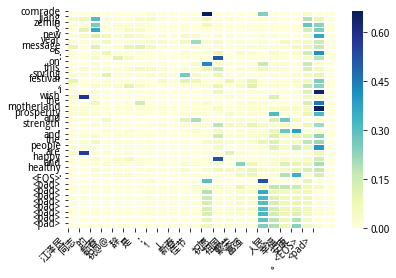

In [7]:
#encoding:utf-8
import numpy as np
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Droid Sans Fallback'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
def heatmap(data, xlabels, ylabels):
    ax = sns.heatmap(data,cmap='YlGnBu',linewidths=.5)
    ax.set_yticks(range(len(ylabels)))
    ax.set_yticklabels(ylabels)
    ax.set_xticks(range(len(xlabels)))
    ax.set_xticklabels(xlabels)
    label_y = ax.get_yticklabels()
    plt.setp(label_y, rotation=360, horizontalalignment='right')
    label_x = ax.get_xticklabels()
    plt.setp(label_x, rotation=45, horizontalalignment='right')
    plt.show()
    plt.show()

test_input = u"江泽民 同志 的 新春 祝@@ 辞 是 : 值 此 新春 佳节 , 祝愿 祖国 繁荣 富强 , 人民 幸福 安康 。<EOS> <pad>"
test_output = "comrade jiang zemin 's new year message is : on this spring festival , i wish \
the motherland prosperity and strength , and the people are happy and healthy . \
<EOS> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>"
xlabels = test_input.split()
ylabels = test_output.split()
print(len(xlabels),len(ylabels))

attention_weight = np.load("weights.npy.npz")
test_enc = attention_weight['arr_0']
test_dec = attention_weight['arr_1']

test_encdec = attention_weight['arr_2']
# a=np.random.rand(10,10)
# xlabels=['A','B','C','D','E','F','G','H','I','J']
# ylabels=['a','b','c','d','e','f','g','h','i','j']
# draw_heatmap(test_encdec[0,0,0,:,:],xlabels,ylabels)
# draw_heatmap(a,xlabels,ylabels)
print(test_encdec[0,0,0,:,:].shape)
heatmap(test_encdec[0,0,0,:,:],xlabels,ylabels)